#Visualizing the model  
This notebook is meant as an example for how to create visualizations
like the ones provided in the appendix.

It is expected that this might need some slight modification depending on the user's 
setup. 

In [1]:
import theano
from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [25]:
import cPickle as pkl
import numpy
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage
import skimage.transform
import skimage.io

from PIL import Image

In [3]:
import capgen
import generate_caps as gencaps
import flickr8k
import flickr30k
import coco

## Loading the model and dataset  

## Training 

In [4]:
datasets = {'flickr8k': (flickr8k.load_data, flickr8k.prepare_data),
             'flickr30k': (flickr30k.load_data, flickr30k.prepare_data),
             'coco': (coco.load_data, coco.prepare_data)}



In [14]:
# location of the model file, the pkl file should be named "model_name.npz.pkl"
model= 'flickr8k_deterministic_model.npz'
# location of the devset split file like the ones in /splits
dev_list = '/home/intuinno/project/pointTeach/data/Flicker8k/Flickr_8k.devImages.txt' 
image_path = '/home/intuinno/project/pointTeach/data/Flicker8k/originalImages/'


# load model model_options
with open('%s.pkl'%model, 'rb') as f:
    options = pkl.load(f)

print 'Loading: ' + options['dataset']

flist = []
with open(dev_list, 'r') as f:
    for l in f:
        flist.append(l.strip())


Loading: flickr8k


In [15]:
# keep aspect ratio, and center crop
def LoadImage(file_name, resize=256, crop=224):
  image = Image.open(file_name)
  width, height = image.size

  if width > height:
    width = (width * resize) / height
    height = resize
  else:
    height = (height * resize) / width
    width = resize
  left = (width  - crop) / 2
  top  = (height - crop) / 2
  image_resized = image.resize((width, height), Image.BICUBIC).crop((left, top, left + crop, top + crop))
  data = numpy.array(image_resized.convert('RGB').getdata()).reshape(crop, crop, 3)
  data = data.astype('float32') / 255
  return data

In [16]:
    load_data, prepare_data = datasets[options['dataset']]

    train, valid, test, worddict = load_data(False, True, False)
    print 'Data loaded'

    word_idict = dict()
    for kk, vv in worddict.iteritems():
        word_idict[vv] = kk
    word_idict[0] = '<eos>'
    word_idict[1] = 'UNK'

... loading data
Data loaded


## Creating the Theano Graph  

In [17]:
    # build the sampling functions and model
    trng = RandomStreams(1234)
    use_noise = theano.shared(numpy.float32(0.), name='use_noise')

    params = capgen.init_params(options)
    params = capgen.load_params(model, params)
    tparams = capgen.init_tparams(params)

    # word index
    f_init, f_next = capgen.build_sampler(tparams, options, use_noise, trng)

Building f_init... Done


In [18]:
    trng, use_noise, \
          inps, alphas, alphas_samples, \
          cost, opt_outs = \
          capgen.build_model(tparams, options)

In [19]:
# get the alphas and selector value [called \beta in the paper]

# create update rules for the stochastic attention
hard_attn_updates = []
if options['attn_type'] == 'stochastic':
    baseline_time = theano.shared(numpy.float32(0.), name='baseline_time')
    hard_attn_updates += [(baseline_time, baseline_time * 0.9 + 0.1 * opt_outs['masked_cost'].mean())]
    hard_attn_updates += opt_outs['attn_updates']
    
f_alpha = theano.function(inps, alphas, name='f_alpha', updates=hard_attn_updates)
if options['selector']:
    f_sels = theano.function(inps, opt_outs['selector'], name='f_sels', updates=hard_attn_updates)

## Generating the Caption and Attention Visualization

(The next five cells can be run over and over to visualize a random image)

In [28]:
idx = numpy.random.randint(0, len(valid[0])) # random image
k = 1 # beam width
use_gt = False # set to False if you want to use the generated sample
gt = valid[0][idx][0] # groundtruth
context = numpy.array(valid[1][valid[0][idx][1]].todense()).reshape([14*14, 512]) # annotations
img = LoadImage(image_path+flist[valid[0][idx][1]])
print 'loading' + image_path+flist[valid[0][idx][1]]

loading/home/intuinno/project/pointTeach/data/Flicker8k/originalImages/2449446913_28fa5b7c75.jpg


In [29]:
if not use_gt:
    sample, score = capgen.gen_sample(tparams, f_init, f_next, context, 
                                      options, trng=trng, k=k, maxlen=200, stochastic=False)
    sidx = numpy.argmin(score)
    caption = sample[sidx][:-1]

In [30]:
# print the generated caption and the ground truth
if use_gt:
    caption = map(lambda w: worddict[w] if worddict[w] < options['n_words'] else 1, gt.split())
words = map(lambda w: word_idict[w] if w in word_idict else '<UNK>', caption)
print 'Sample:', ' '.join(words)
print 'GT:', gt

Sample: A group of children are playing in a field .
GT: A team of baseball players in blue uniforms , walking together on field .


In [31]:
alpha = f_alpha(numpy.array(caption).reshape(len(caption),1), 
                numpy.ones((len(caption),1), dtype='float32'), 
                context.reshape(1,context.shape[0],context.shape[1]))
if options['selector']:
    sels = f_sels(numpy.array(caption).reshape(len(caption),1), 
                   numpy.ones((len(caption),1), dtype='float32'), 
                   context.reshape(1,context.shape[0],context.shape[1]))

## Displaying the Visualization   

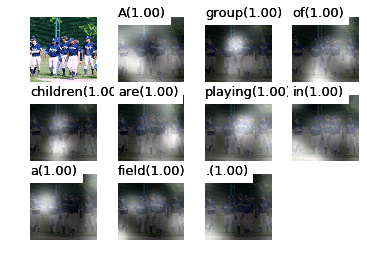

In [32]:
# display the visualization
n_words = alpha.shape[0] + 1
w = numpy.round(numpy.sqrt(n_words))
h = numpy.ceil(numpy.float32(n_words) / w)
        
plt.subplot(w, h, 1)
plt.imshow(img)
plt.axis('off')

smooth = True

for ii in xrange(alpha.shape[0]):
    plt.subplot(w, h, ii+2)
    lab = words[ii]
    if options['selector']:
        lab += '(%0.2f)'%sels[ii]
    plt.text(0, 1, lab, backgroundcolor='white', fontsize=13)
    plt.text(0, 1, lab, color='black', fontsize=13)
    plt.imshow(img)
    if smooth:
        alpha_img = skimage.transform.pyramid_expand(alpha[ii,0,:].reshape(14,14), upscale=16, sigma=20)
    else:
        alpha_img = skimage.transform.resize(alpha[ii,0,:].reshape(14,14), [img.shape[0], img.shape[1]])
    plt.imshow(alpha_img, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
plt.show()